# Combining multiple UMAP models

It is possible to combine together multiple UMAP models, assuming that they are operating on the same underlying data. To get an idea of how this works recall that UMAP uses an intermediate fuzzy topological representation (see [How UMAP Works]()). Given different views of the same underlying data this will generate different fuzzy topological representations. We can apply intersections or unions to these representations to get a new composite fuzzy topological representation which we can then embed into low dimensional space in the standard UMAP way. The key is that, to be able to sensibly intersect or union these representations, there must be one-to-one correspondences between the data samples from the two different views.

To get an idea of how this might work it is useful to see it in practice. Let's load some libraries and get started.

In [1]:
import sklearn.datasets
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import umap.plot

## MNIST digits example

To begin with let's use a relatively familiar dataset -- the MNIST digits dataset that we've used in other sections of this tutorial. The data is (grayscale) 28x28 pixel images of handwritten digits (0 through 9); in total there are 70,000 such images, and each image is unrolled into a 784 element vector.

In [2]:
mnist = sklearn.datasets.fetch_openml("mnist_784")

To ensure we have an idea of what this dataset looks like through the lens of UMAP we can run UMAP on the full dataset.

In [3]:
mapper = umap.UMAP(random_state=42).fit(mnist.data)

<AxesSubplot:>

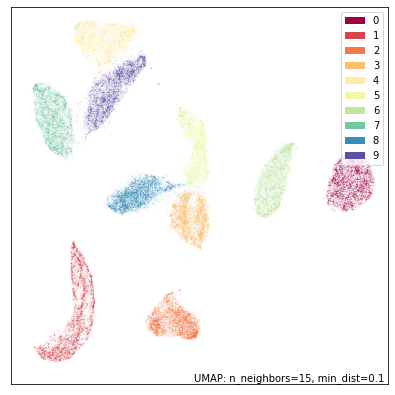

In [4]:
umap.plot.points(mapper, labels=mnist.target, width=500, height=500)

To make the problem more interesting let's carve the datset in two -- not into two sets of 35,000 samples, but instread carve each image in half. That is, we'll end up with 70,000 samples each of which is the top half of the image of the handwritten digit, and another 70,000 samples each of which is the bottom half of the image of the handwritten digit.

In [5]:
top = mnist.data[:, :28 * 14]
bottom = mnist.data[:, 28 * 14:]

This is a little artificial, but it provides us with an example dataset where we have two distinct views of the data which we can still well understand. In practice this situation would be more likely to arise when there are two different data collection processes sampling from the same underlying population. In our case we could simply glus the data back together (hstack the numpy arrays for example), but potentially this isn't feasible as the different data views may have different scales or modalities. So, despite the fact that we could glue things back together in this case, we will proceed as if we can't -- as may be the case for many real world problems.

Let's first look at what UMAP does individually on each dataset. We'll start with the top halves of the digits:

In [6]:
top_mapper = umap.UMAP(random_state=42).fit(top)

<AxesSubplot:>

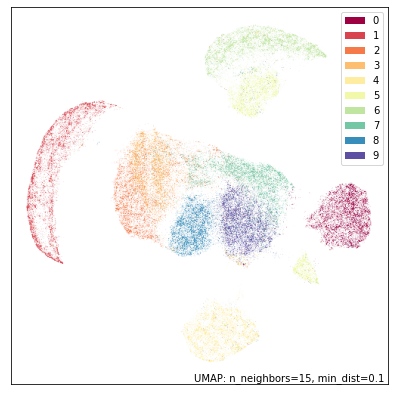

In [7]:
umap.plot.points(top_mapper, labels=mnist.target, width=500, height=500)

While UMAP still manages to mostly separate the different digit classes we can see the results are quite different from UMAP on the full standard MNIST dataset. The twos and threes are blurred together (as we would expect given that we don't have the bottom half of the image wich would let us tell them apart); The twos and threes are also in a large grouping that pulls together all of the eights, sevens and nines (again, what we would expect given only the top half of the digit), while the fives and sixesare somewhat distinct, but clearly are similar to each other. It is only the ones, fours and zeros that are very clearly discernable.

Now let's see what sorts of results we get with the bottom halves of the digits:

In [8]:
bot_mapper = umap.UMAP(random_state=42).fit(bottom)

<AxesSubplot:>

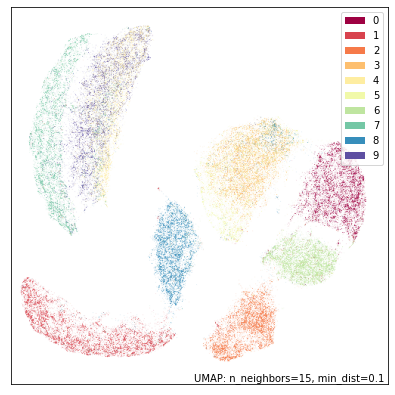

In [9]:
umap.plot.points(bot_mapper, labels=mnist.target, width=500, height=500)

This is clearly a very different view of the data. Now it is the fours and nines that blur together (presumably many of the nines are drawn with straight rather than curved stems), with sevens nearby. The twos and the threes are very distinct from each other, but the threes and the fives are combined (as one might expect given that the bottom halves *should* look similar). Zeros and sixes are distinct, but close to each other. Ones, eights and twos are the most distinctive digits in this view.

So, assuming we can't just glue the raw data together and stick a reasonable metric on it, what can we do? We can perform intersections or unions on the fuzzy topological representations. There is also some work to be done re-asserting UMAP's theoretical assumptions (local connectivity, approximately uniform distributions). Fortunately UMAP makes this relatively easy as long as you have a copy of fitted UMAP models on hand (which we do in this case). To intsersect two models simply use the ``*`` operator; to union them use the ``+`` operator. Note that this will actually take some time since we need to compute the 2D embedding of the combined model.

In [10]:
intersection_mapper = top_mapper * bot_mapper
union_mapper = top_mapper + bot_mapper

With that complete we can visualize the results. First let's look at the intersection:

<AxesSubplot:>

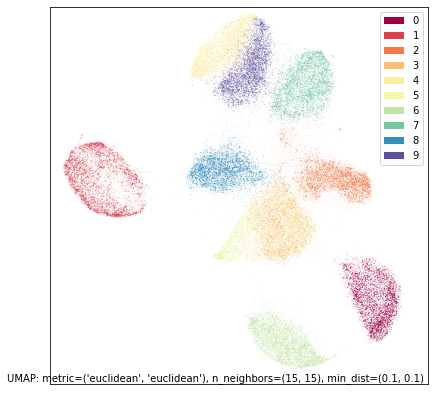

In [11]:
umap.plot.points(intersection_mapper, labels=mnist.target, width=500, height=500)

As you can see, while this isn't as good as a UMAP plot for the full MNIST dataset it has recovered the individual digits quite well. The worst of the remaining overlap is between the threes and fives in the center, which is it still struggling to fully distinguish. But note, also, that we have recovered more of the overall structure than either of the two different individual views, with the layout of different digit classes more closely resembling that of the UMAP run on the full dataset.

Now let's look at the union.

<AxesSubplot:>

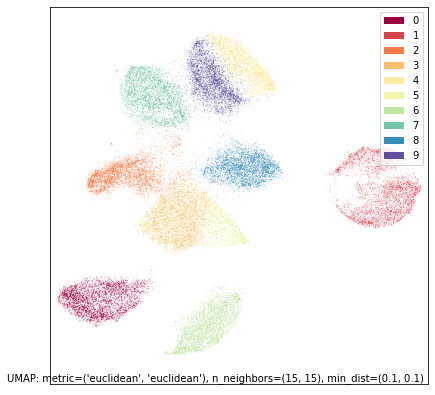

In [12]:
umap.plot.points(union_mapper, labels=mnist.target, width=500, height=500)

Given that UMAP is agnostic to rotation or reflection of the final layout, this is essentially the same result as the intersection since it is almost the relfection of it in the y-axis. This sort of result (intersection and union being similar) is not always the case (in fact it is not that common), but since the underlying structure of the digits dataset is so clear we find that either way of piecing it together from the two half datasets manage to find the same core underlying structure.

If you are willing to try something a little more experimental there is also a third option using the ``-`` operator which effectively insersects with the fuzzy set complement (and is thus not commutative, just as ``-`` implies). The goal here is to try to provide a sense of what the data looks like when we contrast it against a second view.

In [13]:
contrast_mapper = top_mapper - bot_mapper

<AxesSubplot:>

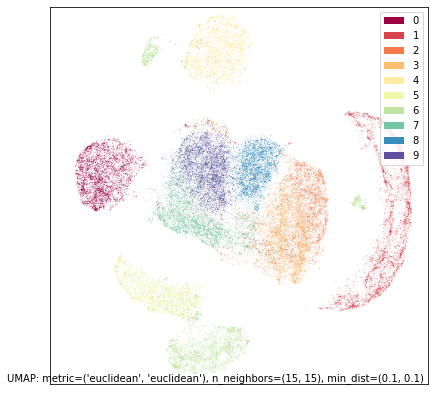

In [14]:
umap.plot.points(contrast_mapper, labels=mnist.target, width=500, height=500)

In this case the result is not overly dissimilar from the embedding of just the top half, so the contrast has perhaps not shown is as much as we might have hoped.

## Diamonds dataset example

Now let's try the same approach on a different dataset where the option of just running UMAP on the full dataset is not available. For this we'll use the diamonds dataset. In this dataset each row represents a different diamond and provides details on the weight (carat), cut, color, clarity, size (depth, table, x, y, z) and price of the given diamond. How these different factors interplay is somewhat complicated.

In [15]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


For our purposes let's take "price" as a "target" variable (as is often the case when the dataset is used in machine learning contexts). What we would like to do is provide a UMAP embedding of the data using the remaining features. This is tricky since we can't exactly use a euclidean metric over the whole thing. What we can do, however, is split the data into two distinct types: the purely numeric features relating to size and weight, and the categorical features of color, cut and clarity. Let's pull each of those feature sets out so we can work with them independently.

In [16]:
numeric = diamonds[["carat", "table", "x", "y", "z"]].copy()
ordinal = diamonds[["cut", "color", "clarity"]].copy()

Now we have a new problem: the numeric features are not at all on the same scales, so any sort of standard distance metric across them will be dominated by those features with the largest ranges. We can correct for that by performing feature scaling. To do that we'll make use of sklearn's ``RobustScaler`` which uses robust statistics (such as the median and interquartile range) to center and rescale the data feature by feature. If we look at the results on the first five rows we see that the different features are all now reasonably comparable, and it is reasonable to apply something like euclidean distance across them.

In [17]:
scaled_numeric = RobustScaler().fit_transform(numeric)
scaled_numeric[:5]

array([[-0.734375  , -0.66666667, -0.95628415, -0.95054945, -0.97345133],
       [-0.765625  ,  1.33333333, -0.98907104, -1.02747253, -1.07964602],
       [-0.734375  ,  2.66666667, -0.90163934, -0.9010989 , -1.07964602],
       [-0.640625  ,  0.33333333, -0.81967213, -0.81318681, -0.79646018],
       [-0.609375  ,  0.33333333, -0.7431694 , -0.74725275, -0.69026549]])

What is the best way to handle the categorical features? If they are purely categorical it would make sense to one-hot encode the categories and use "dice" distance between them. A downside of that is that, with so few categories, it is a very coarse metric which will fail to provide much differentiation. For the diamonds dataset, however, the categories come with a strict order: Ideal cut is better than Premium cut, which is better than Very Good cut and so on. Color grades work similarly, and there is a distinct grading scheme for clarity as well. We can use an ordinal encoding on these categories. Now, while the *ranges* of values may vary, the differences between them are all comparable -- a difference of 1 for each grade level. That means we don't need to rescale this data after the ordinal coding.

In [18]:
ordinal["cut"] = ordinal.cut.map({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4})
ordinal["color"] = ordinal.color.map({"D":0, "E":1, "F":2, "G":3, "H":4, "I":5, "J":6})
ordinal["clarity"] = ordinal.clarity.map({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7})

In [19]:
ordinal

,cut,color,clarity
0,4,1,1
1,3,1,2
2,1,1,4
3,3,5,3
4,1,6,1
...,...,...,...
53935,4,0,2
53936,1,0,2
53937,2,0,2
53938,3,4,1


As noted we can use euclidean as a sensible distance on the rescaled numeric data. On the other hand since the different ordinal categories are entirelty independent of each other, and we have a strict ordinal codin, the socalled "manhattan" metric makes more sense here -- it is simply the sum of the absolute differences in each category. As before we can now train UMAP models on each dataset -- this time, however, since the datasets are different we need different metrics and even different values of ``n_neighbors``.

In [20]:
numeric_mapper = umap.UMAP(n_neighbors=15, random_state=42).fit(scaled_numeric)
ordinal_mapper = umap.UMAP(metric="manhattan", n_neighbors=150, random_state=42).fit(ordinal.values)

We can look at the results of each of these independent views of the dataset reduced to 2D using UMAP. Let's first look at the numeric data on size and weight of the diamonds. We can colour by the price to get some idea of how the dataset fits together.

<AxesSubplot:>

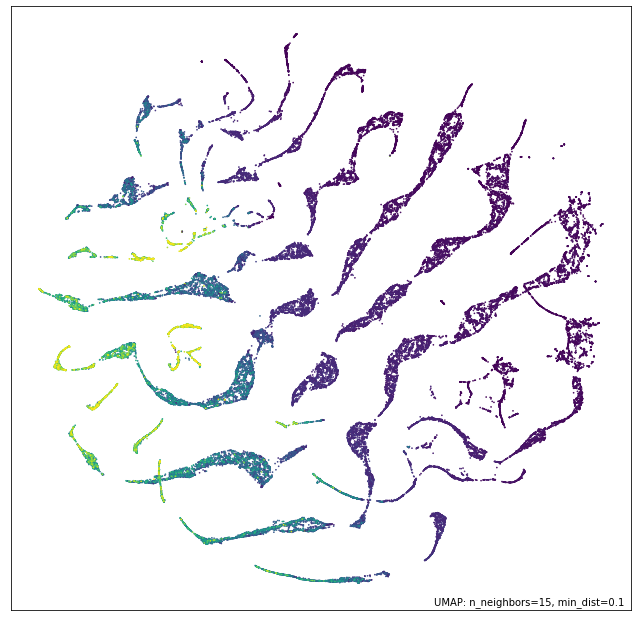

In [21]:
umap.plot.points(numeric_mapper, values=diamonds["price"], cmap="viridis")

We see that while the data generally correlates somewhat with the price of the diamonds there are distinctly different threads in the data, presumbaly corresponding to different styles of cut, and how that results in different sizing of diamonds in the various dimensions, depending on the weight.

In contrast we ca look at the ordinal data. In this case we'll colour it by the different categories as well as by price.

<AxesSubplot:>

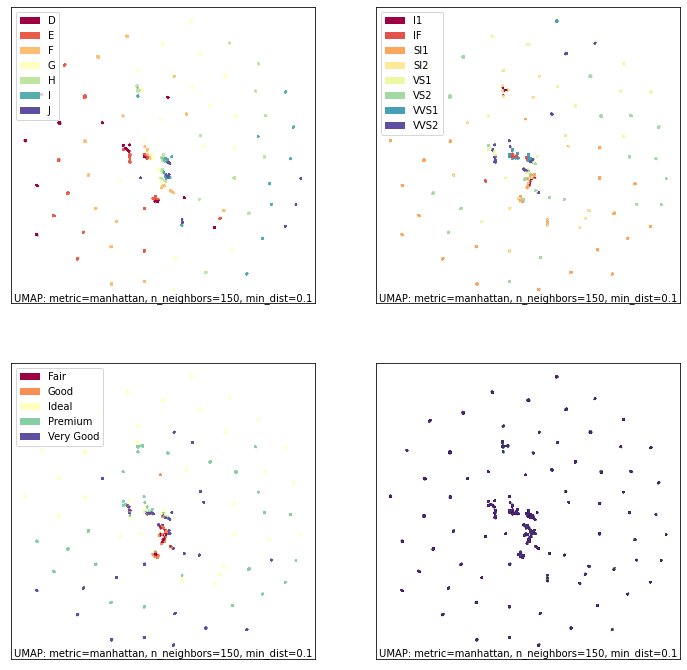

In [26]:
fig, ax = umap.plot.plt.subplots(2, 2, figsize=(12,12))
umap.plot.points(ordinal_mapper, labels=diamonds["color"], ax=ax[0,0])
umap.plot.points(ordinal_mapper, labels=diamonds["clarity"], ax=ax[0,1])
umap.plot.points(ordinal_mapper, labels=diamonds["cut"], ax=ax[1,0])
umap.plot.points(ordinal_mapper, values=diamonds["price"], cmap="viridis", ax=ax[1,1])

As you can see this is a markedly different result! The ordinal data has a relatively coarse metric, since the different categories can only take on a small range of discrete values. This means that, with respect to the trio of color, cut, and clarity, diamonds are largely either almost identical, or quite distinct. The result is very tight groupings which have very high density. You can see a gradient of color from left to right in the plot; colouring by cut or clarity show different stratifications. The combination of these very distinct statifications results in this highly clustered embedding. It is exactly for this reason that we need such a high ``n_neighbors`` value: the very local structure of the data is merely clusters of identical categories; we need to see wider to learn more structure.

Given these radically different views of the data, what do we get if we try to integrate them together? As before we can use the intersection and union operators to simply combine the models. As noted before this is a somnewhat time-consuming operation as a new 2D representation for the combined models needs to be optimized.

In [29]:
intersection_mapper = numeric_mapper * ordinal_mapper
union_mapper = numeric_mapper + ordinal_mapper

Let's start by looking at the intersection; here we are only really decreasing connectivity since edges are assigned the probability of existing in *both* data views (before re-asserting local connectivity and uniform distribution assumptions).

<AxesSubplot:>

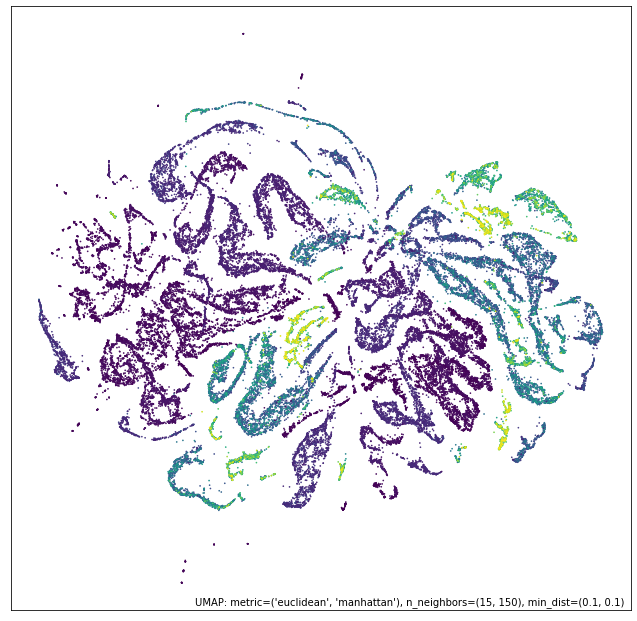

In [30]:
umap.plot.points(intersection_mapper, values=diamonds["price"], cmap="viridis")

What we get most closely represents the numeric data view. Why is this? Because the categorical data view has points either connected with certainty (because they are, or are nearly, identical) or very loosely. The points connected with near certainty are very dense clusters -- almost points in the plot -- and mostly what we are doing with the intersection is breaking up those clusters with the more fine-grained and variable connectivity provided by the numerical data. At th esame time we have shifted the result significantly from the numerical data view on its own; the categorical information has made each cluster more uniform (rather than being a gradient) in its price.

Given this result, what would you expect of the union?

<AxesSubplot:>

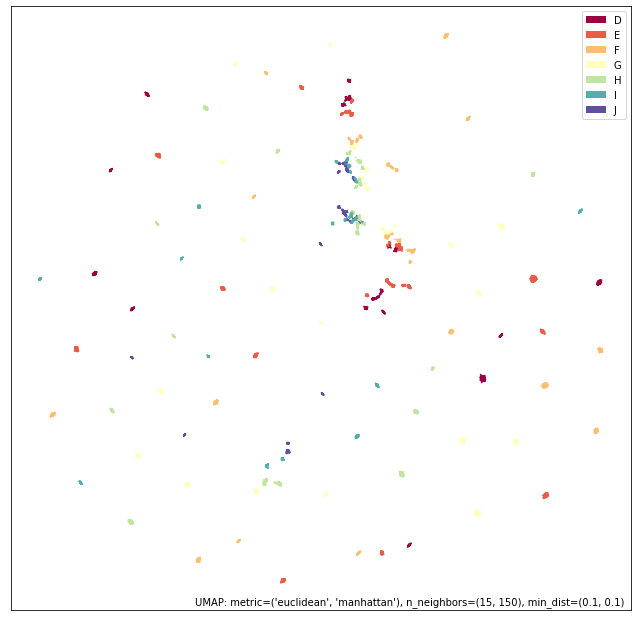

In [31]:
umap.plot.points(union_mapper, labels=diamonds["color"])

What we get in practice looks a lot more like the categorical view of the data. This time we are only *increasing* the connectivity (prior to re-asserting local connectivity and uniform distribution assumptions); thus we reatin most of the structure of the high-connectivity categorical view. Note, however, that we have created more connected and coherent clusters in the center of the plot, showing a range of diamond colors, and the introduction of the numerical size and weight information has induced a rearrangement of the individual clusters around the fringes.

We can go a step further and experiment with the contrast composition method.

In [32]:
contrast_mapper = numeric_mapper - ordinal_mapper

<AxesSubplot:>

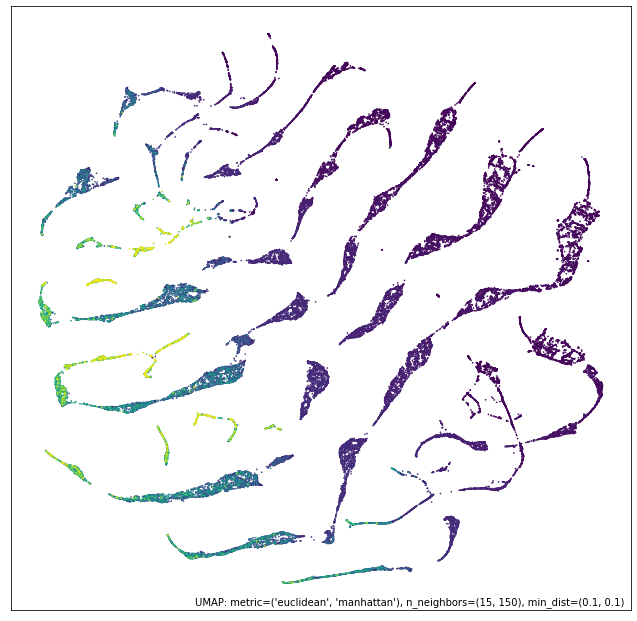

In [33]:
umap.plot.points(contrast_mapper, values=diamonds["price"], cmap="viridis")

Here we see that we've retained a lot of the structure of the numeric data view, but have refined and broken it down further into clear clusters with price gradients running through each of them.

To further demonstrate the power of this approach we can go a step further and intersect a higher ``n_neighbors`` based embedding of the numeric data view with our existing union of numeric and categorical data -- providing a model that is a composition of three simpler models.

In [34]:
intersect_union_mapper = umap.UMAP(random_state=42, n_neighbors=60).fit(numeric) * union_mapper

<AxesSubplot:>

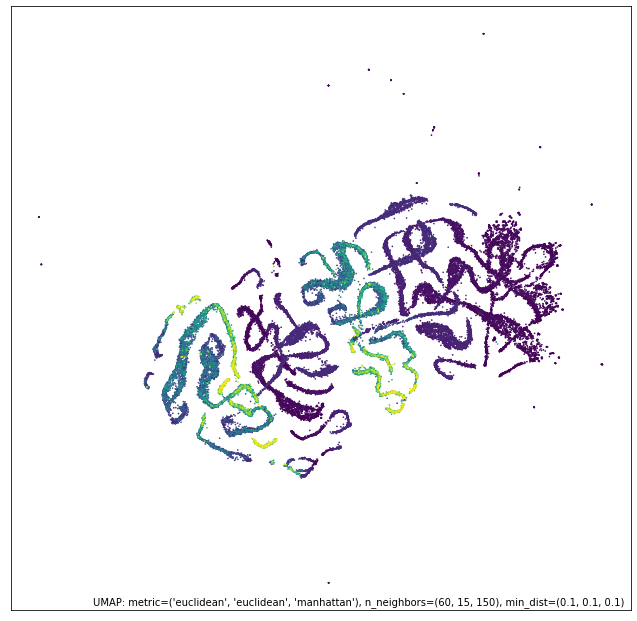

In [35]:
umap.plot.points(intersect_union_mapper, values=diamonds["price"], cmap="viridis")

Here the greater global structure from the larger ``n_neighbors`` value glues together longer strands and we get an interesting result out. In this case it is not necessarily particularly informative, but it is included as a demonstration that even composed models can be composed with each other, stacking together potentially many different views.